# Задание 1. A/B–тестирование

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. 

Для этого мы применяем метод A/B–тестирования. 

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. 

Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.
А также проанализировать основные метрики (метрики выбрать самим)

In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as ss
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy import stats
import pandahouse as ph
from tqdm.auto import tqdm
%matplotlib inline

In [4]:
# файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('Проект_2_groups.csv', sep=';')
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [3]:
groups.dtypes

id      int64
grp    object
dtype: object

In [4]:
# дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
groups_add = pd.read_csv('Проект_2_group_add.csv', sep=',')
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [5]:
#файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('Проект_2_active_studs.csv')
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [6]:
active_studs.dtypes

student_id    int64
dtype: object

In [7]:
#файл с информацией об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('Проект_2_checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [8]:
# посчитаем кол-во в группе А и В в таблице групс
groups.groupby('grp', as_index = False).id.count().sort_values('id', ascending= False)

,grp,id
1,B,59813
0,A,14671


In [9]:
groups.grp.value_counts(normalize=True)*100

B    80.303152
A    19.696848
Name: grp, dtype: float64

В группе В явно больше юзеров, чем в А (80% против 20%), что не совсем корректино для А/В тестирования

In [10]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [11]:
checks.rev.describe()

count     541.000000
mean     1059.752317
std       762.712359
min       199.000000
25%       290.000000
50%       840.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

In [12]:
#зададим параметры для графиков и посмотрим на некоторые зависимости в ДФ
sns.set(rc={'figure.figsize':(20, 6), 'axes.titlesize':12, 'axes.labelsize':12, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30 
           })

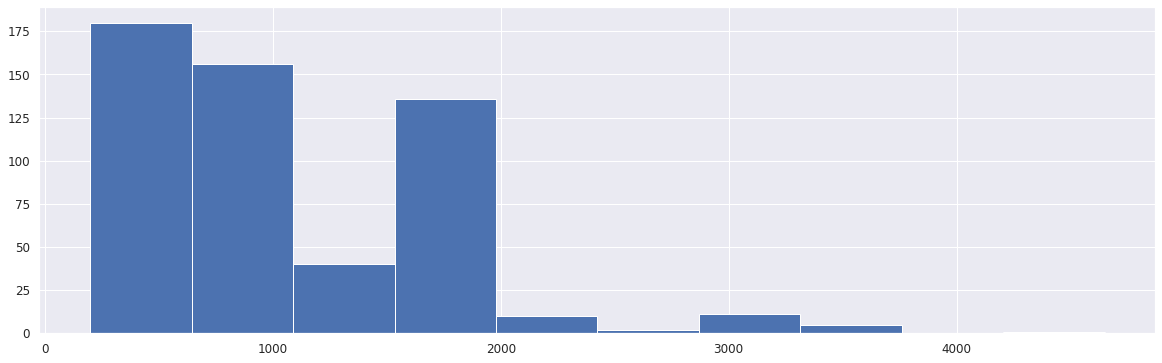

In [13]:
checks['rev'].hist()

In [14]:
checks.groupby('rev', as_index = False).student_id.count().head()

,rev,student_id
0,199.0,46
1,290.0,94
2,398.0,9
3,489.0,3
4,580.0,15


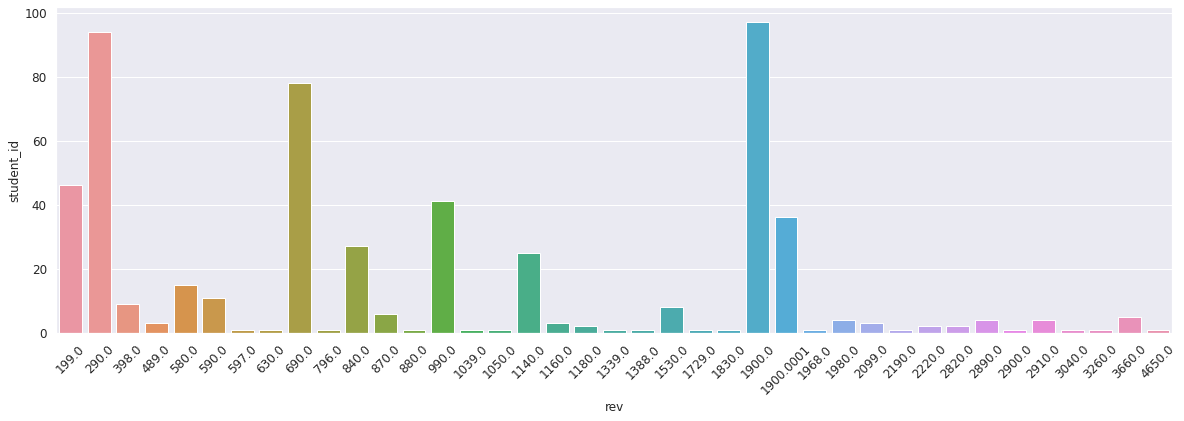

In [15]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=45)
sns.barplot(data=checks.groupby('rev', as_index = False).student_id.count(), x='rev', y='student_id')

Стоит отметить, всплеск оплат в 290, 690 и 1900. 

Посмотрим, в какой из групп было больше оплат на такие суммы

In [16]:
#смержим checks и groups во временный дф. 
checks = checks.rename(columns={'student_id': 'id'}) 
df_temp = groups.merge(checks, on = 'id', how = 'outer')
df_temp

,id,grp,rev
0,1489,B,NaN
1,1627,A,990.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74480,5692572,B,NaN
74481,5692865,B,NaN
74482,5693667,B,NaN
74483,5694419,B,NaN


In [17]:
df_temp.groupby(['grp','rev'], as_index=False).id.count().head()

,grp,rev,id
0,A,199.0,7
1,A,290.0,31
2,A,398.0,2
3,A,489.0,2
4,A,580.0,6


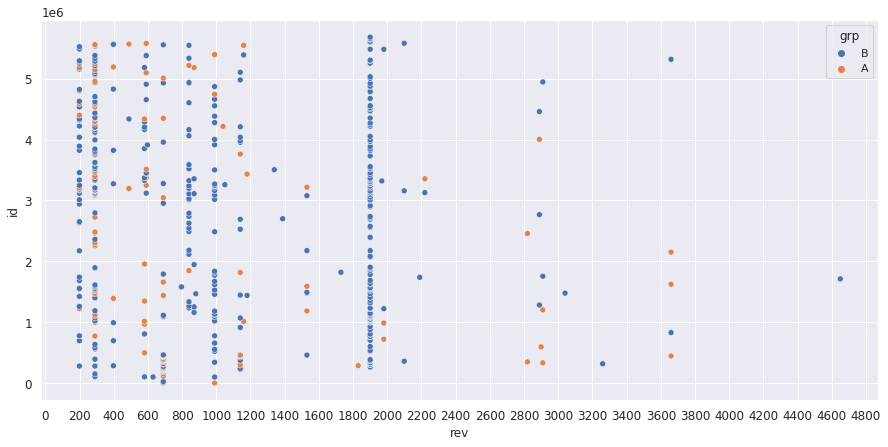

In [18]:
plt.figure(figsize=(15,7))
plt.xticks(np.arange(0,5000,200)) 
sns.scatterplot(data=df_temp, y='id', x='rev', hue = 'grp')

Оплаты в 1900 были в целевой группе (В), как и большинство оплат на сумму 290 в группе В. Но если во втором случае это, возможно, объясняется бОльшим количеством юзеров, то в первом случае это выглядит странным. Проверим это еще раз на следующем этапе при мерже всех 3х ДФ

In [19]:
df_temp_B = df_temp.query('grp == "B"').groupby('rev', as_index=False).id.count()
df_temp_B['percent'] = round((df_temp_B['id'] / df_temp_B.id.sum())*100,0)
df_temp_B.sort_values('percent', ascending=False).head(10)

,rev,id,percent
22,1900.0000,96,22.0
1,290.0000,63,15.0
8,690.0000,59,14.0
0,199.0000,39,9.0
13,990.0000,35,8.0
23,1900.0001,36,8.0
10,840.0000,24,6.0
15,1140.0000,20,5.0
2,398.0000,7,2.0
4,580.0000,9,2.0


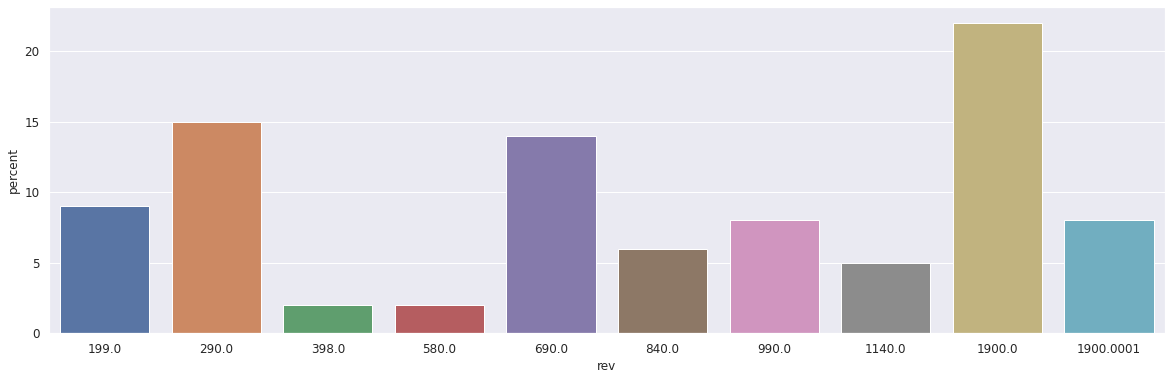

In [20]:
sns.barplot(data=df_temp_B.sort_values('percent', ascending=False).head(10), x="rev", y="percent")

Примерно 30% всех юзеров в группе В купили на сумму 1900. Либо это какая то акция или запущенная программа, что ставит под сомнение проведение А/В тестирования, либо это последствия новой механики оплаты, что маловероятно, так как вряд ли новая механика оплаты привела бы к покупке именно на 1900. Также возможен вариант, что это какая то подписка или постоянный платеж. И группа В приобретала ее чаще

### Подготовка данных для оценки А/В тестирования новой механики оплаты

Будем использовать три дф groups, active_studs и checks.
Необходимо смерджить эти 3 дф в один

In [21]:
# для мерджа переименуем столбец, чтобы были одинаковые названия
active_studs = active_studs.rename(columns={'student_id': 'id'}) 
active_studs.head()

,id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [22]:
# добавим столбец признака 1 в таблицу active_studs, для того чтобы после мерджа у людей, заходивших в приложение был признак

In [23]:
active_studs['activity'] = 1
active_studs.head()

,id,activity
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [24]:
df = groups.merge(active_studs, on = 'id', how = 'outer')
df

,id,grp,activity
0,1489,B,NaN
1,1627,A,1.0
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74492,5740903,NaN,1.0
74493,5760471,NaN,1.0
74494,5728431,NaN,1.0
74495,5723648,NaN,1.0


In [25]:
# у некоторых людей нет группы, но есть активность. возможно это ошибка данных или ошибка сплитования групп.
# но нужно проверить наличие этих id в groups_add. возможно, эти юзеры есть в обновленных данных

In [26]:
# отберем только юзеров без групп
df_nan = df[df.grp.isnull()]
df_nan

,id,grp,activity
74484,5723133,NaN,1.0
74485,5951797,NaN,1.0
74486,5730382,NaN,1.0
74487,5739944,NaN,1.0
74488,5945085,NaN,1.0
74489,5700613,NaN,1.0
74490,5729371,NaN,1.0
74491,5777081,NaN,1.0
74492,5740903,NaN,1.0
74493,5760471,NaN,1.0


In [27]:
# смержим дф с юзерами без групп с дф с обновленными данными.
merge_nan = df_nan.merge(groups_add, on = 'id', how = 'left')
merge_nan

,id,grp_x,activity,grp_y
0,5723133,NaN,1.0,A
1,5951797,NaN,1.0,B
2,5730382,NaN,1.0,B
3,5739944,NaN,1.0,B
4,5945085,NaN,1.0,B
5,5700613,NaN,1.0,B
6,5729371,NaN,1.0,A
7,5777081,NaN,1.0,B
8,5740903,NaN,1.0,B
9,5760471,NaN,1.0,B


Да, так и есть эти 13 значений есть в обновленной таблице. Значит это не ошибка. Но в данном А/В тестировании эти юзеры нам не нужны

In [28]:
# переименуем столбец в табллице checks
checks = checks.rename(columns={'student_id': 'id'}) 
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [29]:
#смреджим дф с checks
df = df.merge(checks, how = 'outer', on="id")
df

,id,grp,activity,rev
0,1489,B,NaN,NaN
1,1627,A,1.0,990.0
2,1768,B,NaN,NaN
3,1783,B,NaN,NaN
4,1794,A,NaN,NaN
...,...,...,...,...
74492,5740903,NaN,1.0,1900.0
74493,5760471,NaN,1.0,NaN
74494,5728431,NaN,1.0,NaN
74495,5723648,NaN,1.0,NaN


Посмотрим на распределение оплат с учетом активности юзеров. Проверим нет ли такого, что была оплата , но юзер не заходил в приложение

In [30]:
df.fillna(0).query('activity == 0 and rev != 0') \
            .groupby(['rev','grp'], as_index= False).id.count() \
            .sort_values('rev', ascending= False)

,rev,grp,id
18,1980.0000,A,1
17,1900.0001,B,1
16,1900.0000,B,4
15,1180.0000,B,1
14,1140.0000,B,11
13,1140.0000,A,3
12,990.0000,B,18
11,990.0000,A,1
10,840.0000,B,3
9,690.0000,B,46


Видим, что пользователи, не заходившие в приложение (активность =0), все равно существили оплату. И также средни них есть оплаты на 1900. Предыдущее замечение о 30% оплат на 1900 и текущее наблюдение позволяет склоняться к предположению, что все-таки это какая то подписка. Иначе, как может юзер совершить покупку, не заходя в приложение 

In [31]:
df.groupby(['grp', 'activity'], as_index = False).agg({'id':'count','rev':'sum'})

,grp,activity,id,rev
0,A,1.0,1535,72820.0000
1,B,1.0,6793,393074.0035


In [32]:
#пользователей без групп можно убрать
df = df.dropna(subset=['grp'])
df.tail()

,id,grp,activity,rev
74479,5692459,B,NaN,NaN
74480,5692572,B,NaN,NaN
74481,5692865,B,NaN,NaN
74482,5693667,B,NaN,NaN
74483,5694419,B,NaN,NaN


In [33]:
# заменим nan на 0
df_for_work = df.fillna(0)
df_for_work

,id,grp,activity,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0
...,...,...,...,...
74479,5692459,B,0.0,0.0
74480,5692572,B,0.0,0.0
74481,5692865,B,0.0,0.0
74482,5693667,B,0.0,0.0


In [34]:
# добавим колонку с признаком оплаты
df_for_work['payment'] = np.where(df_for_work.rev > 0, 1, 0)
df_for_work

,id,grp,activity,rev,payment
0,1489,B,0.0,0.0,0
1,1627,A,1.0,990.0,1
2,1768,B,0.0,0.0,0
3,1783,B,0.0,0.0,0
4,1794,A,0.0,0.0,0
...,...,...,...,...,...
74479,5692459,B,0.0,0.0,0
74480,5692572,B,0.0,0.0,0
74481,5692865,B,0.0,0.0,0
74482,5693667,B,0.0,0.0,0


In [35]:
# добавим признак активного и заплатившего юзера
df_for_work['act_and_pay'] = np.where((df_for_work.rev > 0) & (df_for_work.activity > 0), 1, 0)
df_for_work

,id,grp,activity,rev,payment,act_and_pay
0,1489,B,0.0,0.0,0,0
1,1627,A,1.0,990.0,1,1
2,1768,B,0.0,0.0,0,0
3,1783,B,0.0,0.0,0,0
4,1794,A,0.0,0.0,0,0
...,...,...,...,...,...,...
74479,5692459,B,0.0,0.0,0,0
74480,5692572,B,0.0,0.0,0,0
74481,5692865,B,0.0,0.0,0,0
74482,5693667,B,0.0,0.0,0,0


In [36]:
df_for_work.groupby(['payment','grp'], as_index=False).count()

,payment,grp,id,activity,rev,act_and_pay
0,0,A,14564,14564,14564,14564
1,0,B,59380,59380,59380,59380
2,1,A,107,107,107,107
3,1,B,433,433,433,433


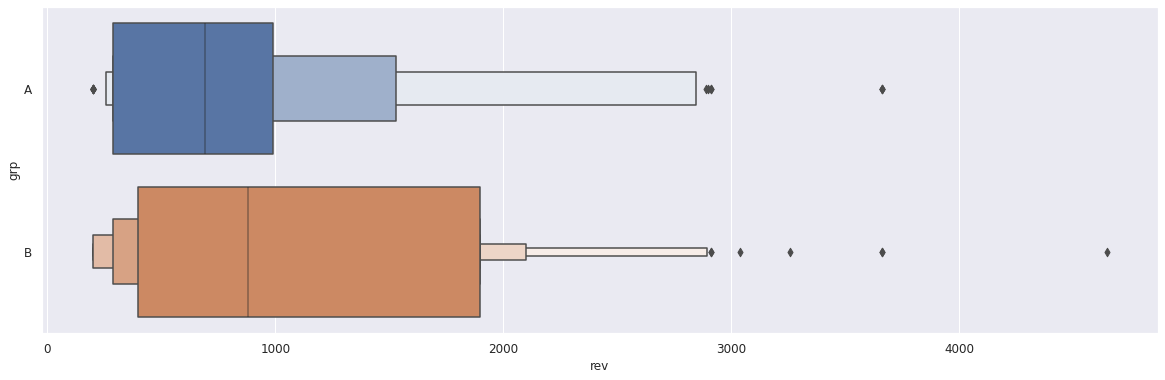

In [37]:
sns.boxenplot(data=df_for_work.query("rev > 0"), y="grp", x="rev")

Видим, что есть выбросы по оплатам.

### На какие метрики будем смотреть в ходе анализа и почему?

#### Convetrion Rate -конверсия в покупку. 
Основная метрика. Ни одна другая метрика не дает такого представления по результативности продвижения. Это отношение числа посетителей, выполнивших на нём какие-либо целевые действия (у нас оплата), к общему числу посетителей, выраженное в процентах. 

#### ARPU Average Revenue Per User = Revenue / Users. 
Это средняя прибыль компании от одного пользователя. В расчёт берётся вся аудитория: и платящие, и неплатящие пользователи. Таким образом, ARPU – это показатель монетизационной эффективности проекта: чем он выше, тем больше денег приносит один пользователь за период.

#### ARPPU Average Revenue Per Paying User = Revenue / Paying Users- 
это средний доход исключительно от каждого платящего клиента. Здесь в знаменателе используется куда меньшее количество пользователей (только совершившие оплату), чем при расчёте ARPU. А это значит, что ARPPU как правило значительно выше, чем ARPU. Эта метрика показывает реакцию именно платящих пользователей.

#### ARPAU Average Revenue Per Active User - 
отношение выручки к количеству *активных* студентов. 

Посчитаем выбранные метрики. Сделаем отдельный датафрейм metrics.

In [38]:
# для начала сгруппируем по группам, и посчитаем в них количество юзеров с оплатой (payment), количество юзеров всего (id), 
# сумму выручки (rev) и кол-во активных юзеров (activity)
metrics = df_for_work.groupby('grp',as_index = False) \
                     .agg({'rev':'sum', 'id':'count', 'payment':'sum','activity':'sum', 'act_and_pay':'sum'})
metrics = metrics.rename(columns={'rev':'revenue','payment':'num_pay_id','id':'num_id','activity':'num_activ_id'})
metrics

,grp,revenue,num_id,num_pay_id,num_activ_id,act_and_pay
0,A,92096.0000,14671,107,1535.0,78
1,B,479330.0036,59813,433,6793.0,313


In [39]:
# посчитаем CR конверсию (число юзеров оплативших и зашедших в приложение/число юзеров зашедших в приложение)
metrics['CR'] = round(metrics.act_and_pay/metrics.num_activ_id*100,2)
metrics

,grp,revenue,num_id,num_pay_id,num_activ_id,act_and_pay,CR
0,A,92096.0000,14671,107,1535.0,78,5.08
1,B,479330.0036,59813,433,6793.0,313,4.61


In [40]:
# Считаем ARPPU и ARPAU и ARPU
metrics['ARPU'] = metrics.revenue/metrics.num_id
metrics['ARPPU'] = metrics.revenue/metrics.num_pay_id
metrics['ARPAU'] = metrics.revenue/metrics.num_activ_id
metrics

,grp,revenue,num_id,num_pay_id,num_activ_id,act_and_pay,CR,ARPU,ARPPU,ARPAU
0,A,92096.0000,14671,107,1535.0,78,5.08,6.277418,860.710280,59.997394
1,B,479330.0036,59813,433,6793.0,313,4.61,8.013810,1106.997699,70.562344


Видим, что конверсия в группе В (целевой) ниже, однако ARPU, ARPAU и ARPPU выше. 

Необходимо посмотреть на распределение для выбора теста для А/В тестирования

In [41]:
df_for_work_A = df_for_work[['grp', 'rev']].query('grp == "A" and rev>0')
df_for_work_A

,grp,rev
1,A,990.0
406,A,690.0
2041,A,690.0
2231,A,690.0
2393,A,690.0
...,...,...
73140,A,990.0
73966,A,1160.0
74022,A,290.0
74079,A,489.0


In [42]:
df_for_work_B = df_for_work[['grp', 'rev']].query('grp == "B" and rev>0')
df_for_work_B

,grp,rev
39,B,690.0
121,B,690.0
125,B,690.0
220,B,990.0
223,B,630.0
...,...,...
74251,B,1900.0
74365,B,1900.0
74381,B,1900.0
74402,B,1900.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


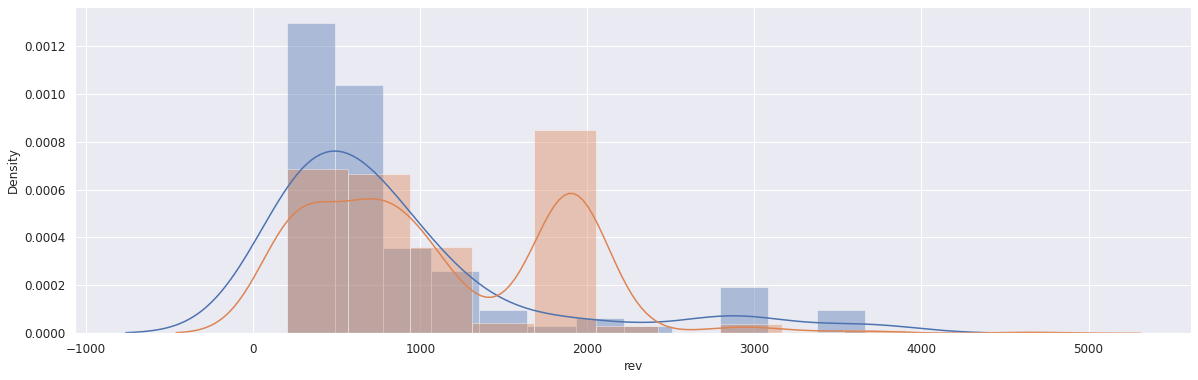

In [43]:
sns.distplot(df_for_work_A['rev'])
sns.distplot(df_for_work_B['rev'])

По графику видно, что распределения не нормальные. И в группе В две моды

Количество наблюдений у нас больше 30, выборки независимые, поэтому тут можно использовать т-тест. Он устойчив по отношению к форме распределения и формы не обязательно должны быть одинаковыми. Также будем использовать бутстрап

Сформулируем гипотезы. 

Будем проверять средние значения переменных rev (выручка) в df_for_work_A и df_for_work_B

H0 - новая механика оплаты не оказывает влияния (средние значения одинаковые), эксперимент неудачный. Мехника оплаты отклоняется

H1 - новая механика оплаты оказывает влияние (в тестовой группе среднее значение выручки выше), эксперимент удачный. Мехника оплаты принимается.

In [44]:
#T-test
stats.ttest_ind(df_for_work_A['rev'],df_for_work_B['rev'])

Ttest_indResult(statistic=-3.013977768530976, pvalue=0.0026999933026625785)

In [45]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

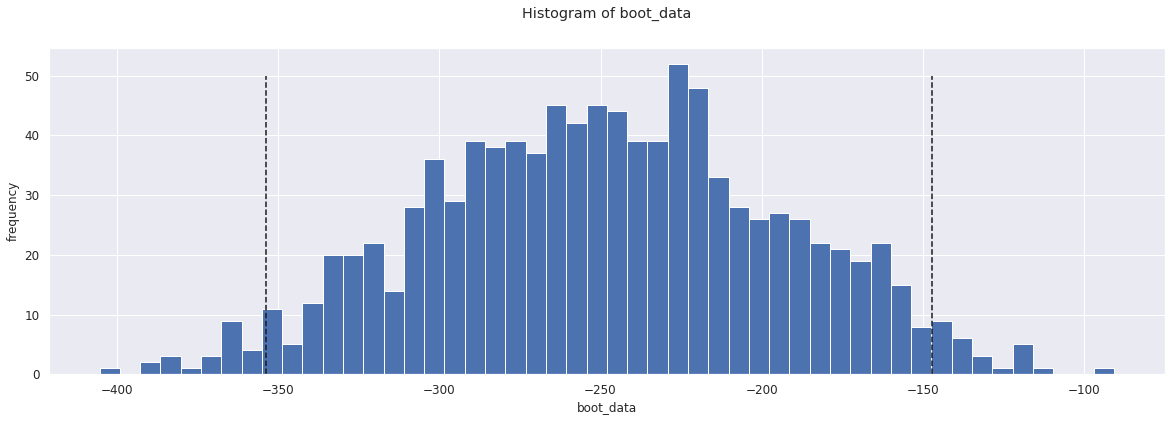

In [46]:
booted_data_mean = get_bootstrap(df_for_work_A.rev,
                            df_for_work_B.rev,
                            boot_it = 1000,
                            statistic = np.mean, # интересующая нас статистика
                            bootstrap_conf_level = 0.95 # уровень значимости
                           ) 
# в результате хранится разница двух распределений, ДИ и pvalue

In [47]:
booted_data_mean["p_value"]

4.444273042074015e-06

По большинству статистических данных, кроме CR, который ниже из-за бОльшего количества пользователей, новая система оплаты показала себя хорошо, дав бОльшие значения для измеряемых параметров. Также в обоих случаях pvalue < 0.05, следовательно, нулевая гипотеза неверна и результат эксперемента можно было бы считать успешным и внедрять новый экран оплаты. 

#### Но, 
так как мы объявили основное метрикой - конверсию, а она в тестовой группе ниже, проведем стат оценку конверсии, и  проверим гипотезу о равенстве конверсий в группах.

H0: у конверсии в группах нет различий

H1: у конверсии в группах есть различия.

In [48]:
df_stat_CR = df_for_work.query('activity > 0') \
                        .groupby(['payment','grp'], as_index=False) \
                        .id.count()
df_stat_CR

,payment,grp,id
0,0,A,1457
1,0,B,6480
2,1,A,78
3,1,B,313


In [49]:
df_stat_CR_pivot=df_stat_CR.pivot(index='grp',columns='payment', values='id')
df_stat_CR_pivot

payment,0,1
grp,,
A,1457,78
B,6480,313


In [50]:
ss.chi2_contingency(df_stat_CR_pivot,correction=False)

(0.6280206142073419,
 0.4280822964525912,
 1,
 array([[1462.93167627,   72.06832373],
        [6474.06832373,  318.93167627]]))

In [51]:
# p-value
ss.chi2_contingency(df_stat_CR_pivot,correction=False)[1]

0.4280822964525912

Поскольку p-значение (0,428) теста не меньше 0,05, мы не можем отвергнуть нулевую гипотезу. Это означает, что у нас нет достаточных доказательств, чтобы сказать, что существует связь между группами. И, значит, различие в конверсии между группами не стат значимо

#### Вывод: 
Различие в конверсии между группами не является статистически значимым.

В целевой группе В преобладает платеж на 1900. Как говорилось ранее, это могла бы быть акция или подписка, и, значит, результат теста искажен. Размеры групп разные. Количество людей в группе В значительно выше кол-ва в группе А. При этом перекос именно в пользу тестовой группы. Такой дисбаланс также ставит под сомнение тест. 

#### Как итог: 
на данный момент нет однозначного решения о положительном результате эксперимента. Необходимо провести заново эксперимент,  при этом уравнять группы по кол-ву людей, и убрать доп факторы (акции). При текущих данных не рекомендовано запускать новую механику оплаты

# Задание 2. SQL

## 2.1 Очень усердные ученики

### 2.1.1 Условие
Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

### 2.1.2 Задача

Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов (Дана таблица default.peas).

NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

In [52]:
host = 'https://clickhouse.lab.karpov.courses' 
database = 'default'
user = 'student'
password = 'dpo_python_2020'

connection = {'host': host
             ,'database':database
             ,'user': user
             ,'password': password}

In [53]:
# выгрузим таблицу в ДФ, чтобы посмотреть на данные
query= '''
SELECT st_id, toDateTime(timest) as timest, correct, subject
FROM default.peas
'''
peas = ph.read_clickhouse(query, connection=connection)
peas

,st_id,timest,correct,subject
0,100379,2021-10-30 13:32:29,1,Theory of probability
1,100379,2021-10-30 14:11:19,0,Vizualization
2,100379,2021-10-30 15:54:22,1,Theory of probability
3,100379,2021-10-30 16:44:50,1,Vizualization
4,100379,2021-10-30 17:15:05,1,Theory of probability
...,...,...,...,...
13240,996911,2021-10-31 08:41:00,1,Statistics
13241,996911,2021-10-31 09:12:28,0,Statistics
13242,996911,2021-10-31 09:33:39,0,Statistics
13243,996911,2021-10-31 09:46:44,1,Statistics


In [54]:
peas.timest.min()

Timestamp('2021-10-30 13:00:00')

In [55]:
peas.timest.max()

Timestamp('2021-10-31 17:29:52')

In [56]:
peas.dtypes

st_id              object
timest     datetime64[ns]
correct              int8
subject            object
dtype: object

In [57]:
query2= '''
select count(st_id) as num_students
from(
SELECT st_id, sum(correct) as sum_correct
from default.peas
where correct = 1
group by st_id)
where sum_correct >=20
'''
diligent_std = ph.read_clickhouse(query2, connection=connection)
diligent_std

,num_students
0,136


### Ответ: 136 очень усердных студентов.

## 2.2 Оптимизация воронки

### 2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

### 2.2.2 Задача

Дана таблицы: default.peas (см. выше), default.studs

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

ARPU 

ARPAU 

CR в покупку 

СR активного пользователя в покупку 

CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

*Активным* считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

*Активным* по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [154]:
query2= '''
select s.test_grp, 
round((sum(sum_money)/count(st_id)),2) as ARPU,
round((sumIf(sum_money,sum_correct >10)/countIf(st_id,sum_correct >10)),2) as ARPAU,
round((countIf(st_id, sum_money>0)/count(st_id))*100,2) as CR,
round((countIf(st_id, sum_money>0 and sum_correct >10)/countIf(st_id,sum_correct >10))*100,2) as CR_acvtive,
round((countIf(st_id, sum_correct_math>0 and sum_money_math >0)/countIf(st_id,sum_correct_math >= 2))*100,2) as CR_acvtive_math
from default.studs as s
left join (
        select (case when t1.st_id = '' then t2.st_id else t1.st_id end) as st_id, 
        sum_correct, sum_correct_math, sum_money, sum_money_math
        from (
                select 
                st_id, 
                sum(correct) as sum_correct,
                sum(case when subject = 'Math' then correct else 0 end) as sum_correct_math
                from default.peas
                group by st_id
              ) as t1
        full join 
              (        
                select 
                st_id, 
                sum(money) as sum_money, 
                sum(case when subject = 'Math' then money else 0 end) as sum_money_math
                from default.final_project_check
                group by st_id
              ) as t2
        on t1.st_id = t2.st_id
         ) as t12
on s.st_id = t12.st_id
group by s.test_grp
'''
df_sql = ph.read_clickhouse(query2, connection=connection)

In [155]:
df_sql

,test_grp,ARPU,ARPAU,CR,CR_acvtive,CR_acvtive_math
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52


# Задание 3. Python

## 3.1 Задача

Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [60]:
def add_new_data():
    '''
    функция добавляет информацию из нового файла. 
    Добавляет нужные колонки с признаком активности 
    Объединяет датафреймы в один
    Создает новый датафрейм с метриками на основе датафрейма на предыдущем шаге
    '''
# чтение дф    
    groups      = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-eleneva/Eleneva/CSV/Проект_2_groups.csv', sep=';')
    groups_add  = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-eleneva/Eleneva/CSV/Проект_2_group_add.csv', sep=',')
    active_students= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-eleneva/Eleneva/CSV/Проект_2_active_studs.csv')
    checks      = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-i-eleneva/Eleneva/CSV/Проект_2_checks.csv', sep=';')
    
    checks = checks.rename(columns={'student_id': 'id'}) 
    active_studs['activity'] = 1
    
    groups_new = pd.concat([groups,groups_add])
    merge1 =groups_new.merge(active_studs, on = 'id', how = 'left')
    new_df = merge1.merge(checks, how = 'left', on="id")
    new_df = new_df.fillna(0)
    new_df['payment'] = np.where(new_df.rev > 0, 1, 0)
    new_df['act_and_pay'] = np.where((new_df.rev > 0) & (new_df.activity > 0), 1, 0)
    
# новый дф для метрик
    metric_df = new_df \
                .groupby('grp',as_index = False) \
                .agg({'rev':'sum','id':'count','payment':'sum','activity':'sum', 'act_and_pay':'sum'}) \
                .rename(columns={'rev':'revenue','payment':'num_pay_id','id':'num_id','activity':'num_activ_id'}) 
    metric_df['CR'] = round(metric_df.act_and_pay/metric_df.num_activ_id*100,2)
    metric_df['ARPU'] = metric_df.revenue/metric_df.num_id
    metric_df['ARPPU'] = metric_df.revenue/metric_df.num_pay_id
    metric_df['ARPAU'] = metric_df.revenue/metric_df.num_activ_id
    
    return metric_df           

In [61]:
add_new_data()

,grp,revenue,num_id,num_pay_id,num_activ_id,act_and_pay,CR,ARPU,ARPPU,ARPAU
0,A,92096.0000,14693,107,1538.0,78,5.07,6.268019,860.710280,59.880364
1,B,481230.0036,59883,434,6803.0,314,4.62,8.036171,1108.824893,70.737910


In [62]:
def charts(metric_df):   
    
    '''
    Функция строит графики по метрикам
    '''
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(22, 6)) 
        
    sns.barplot(x=metric_df.grp, y='CR', data=metric_df, ax=axes[0])
    axes[0].set(title='CR')
    axes[0].set(xlabel='')
    axes[0].set(ylabel='')
        
    sns.barplot(x=metric_df.grp,y='ARPU',data=metric_df,ax=axes[1])
    axes[1].set(title='ARPU')
    axes[1].set(xlabel='')
    axes[1].set(ylabel='')

    sns.barplot(x=metric_df.grp,y='ARPPU',data=metric_df, ax=axes[2])
    axes[2].set(title='ARPPU')
    axes[2].set(xlabel='')
    axes[2].set(ylabel='')
    
    sns.barplot(x=metric_df.grp, y='ARPAU',data=metric_df,ax=axes[3])
    axes[3].set(title='ARPAU')
    axes[3].set(xlabel='')
    axes[3].set(ylabel='')
    
    
    return plt.show()

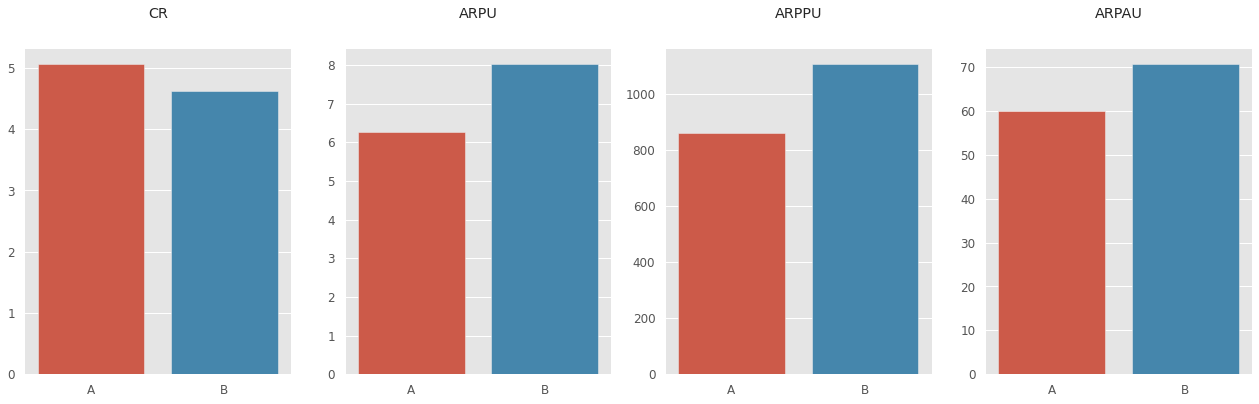

In [63]:
charts(add_new_data())